In [23]:
! pip install fast_ml --quiet
! pip install opencv-python
! pip install pandas
! pip install --upgrade pip

In [24]:
! pip install seaborn
! pip install tensorflow
! pip install tqdm

  Using cached tensorflow-2.17.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (4.1 kB)
Using cached tensorflow-2.17.0-cp311-cp311-macosx_12_0_arm64.whl (236.2 MB)


# Initial setup (Always run)

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)
import seaborn as sns
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Flatten
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from fast_ml.model_development import train_valid_test_split
import pathlib

2.17.0


# Preprocessing 

In [4]:
tsinghua_image_path = os.getcwd()+'/dog_classes'

In [6]:
# Function to load and preprocess a single image
# Image is resized, converted to array, and normalised
def parse_image(image_path, target_size=(224, 224)):
    # Load and decode the image
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)  # Convert to array (height, width, channels)

    # Normalize to [0, 1]
    image /= 255.0  # Normalization is often necessary for model training
  
    return image

# Create a function to calculate the mean over the entire dataset
def compute_dataset_mean(image_paths):
    total_sum = np.zeros(3)  # We split into 3, to calculate the pr channel mean - good for deep learning models
    total_count = 0

    for img_path in image_paths:

        full_img_path = os.path.join(tsinghua_image_path, img_path)  # Join the base path with the image path

        parsed_img = parse_image(full_img_path, target_size=(224, 224))

        total_sum += np.mean(parsed_img, axis=(0, 1))  # Mean over width, height for each channel -> we only calculate the mean over the one picture here
        total_count += 1

    dataset_mean = total_sum / total_count
    return dataset_mean

# Compute the feature wise mean (over the whole dataset)
#dataset_mean = compute_dataset_mean(df['Image path'].tolist())
#print("Feature wise Mean: ", dataset_mean)

# Function to apply feature-wise centering
def zero_centering(image, dataset_mean):
    return image - dataset_mean

# Load images into the DataFrame and apply zero-centering
def load_images_into_dataframe(df, dataset_mean):
    # Create a list to hold the processed images
    images = []

    for image_path in df['Image path']:
        full_image_path = os.path.join("dog_classes/", image_path)
        #print(full_image_path)
        image_array = parse_image(full_image_path)  # Load and preprocess the image - is array
        image = zero_centering(image_array, dataset_mean)  # Apply zero centering
        #image /= 255.0
        images.append(image)  # Append the processed image to the list

    # Add the images as a new column in the DataFrame
    df.insert(2, 'Image', images)

    return df

# Load images into the DataFrame
#df = load_images_into_dataframe(df, dataset_mean)

# Now the DataFrame contains paths, labels, and processed images
#df.head(5)


# Visualize data

In [23]:
tsinghua_image_path = os.getcwd()+'/dog_classes'
classes = os.listdir(tsinghua_image_path)

print('Number of dog breeds: ', len(classes))

#Make empty array to save info about dog breeds and their frequencies
class_names_and_frequencies = []

#Loop through all classes
for class_name in classes:
    class_path = os.path.join(tsinghua_image_path, class_name)
    
    if class_name.startswith('.'):
        print(f"Skipping hidden file: {class_name}")
        continue
    
    dog_name = class_name.split('-')[2] #We only want after the second occurence of "-" in the directory name
    
    
    dog_frequency = len(os.listdir(class_path))
    class_names_and_frequencies.append((dog_name, dog_frequency))

#Get the dataframe
df = pd.DataFrame(class_names_and_frequencies, columns = ['Breeds', 'Frequency'])
print('Total number of images :', df['Frequency'].sum())

Number of dog breeds:  131
Skipping hidden file: .DS_Store
Total number of images : 70432


In [24]:
#Check if it looks alright
df.head()

,Breeds,Frequency
0,schipperke,201
1,Australian_Shepherd,245
2,Shetland_sheepdog,274
3,black_and_tan_coonhound,225
4,Gordon_setter,228


<AxesSubplot: title={'center': 'Frequency of dog breeds in descending order'}, xlabel='Frequency', ylabel='Breeds'>

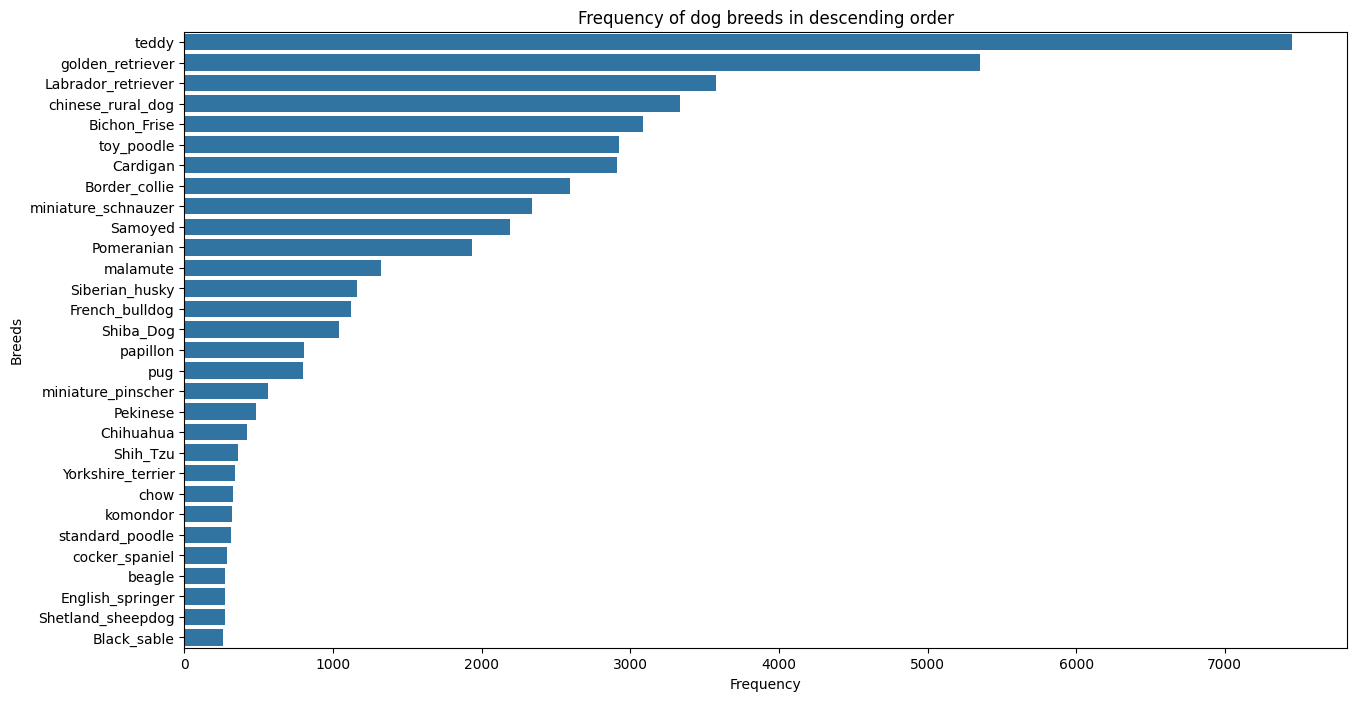

In [25]:
#Plot the distribution of dog breeds
plt.figure(figsize=(15,8))
plt.title('Frequency of dog breeds in descending order')
sns.barplot(x = 'Frequency', y = 'Breeds', data = df.sort_values('Frequency', ascending = False).head(30))

# Preprocessing

In [4]:
#Array containing all data
dogs = []

tsinghua_image_path = os.getcwd()+'/dog_classes'
classes = os.listdir(tsinghua_image_path)

classes = classes[:5]
print(len(classes))

for dog_breed in classes:
    if dog_breed.startswith('.'):
        print(f"Skipping hidden file: {dog_breed}")
        continue
    for image_id in os.listdir(os.path.join(tsinghua_image_path, dog_breed)):
        path = os.path.join(dog_breed, image_id)
        label = dog_breed.split('-')[2]
        dogs.append((path, label))

df = pd.DataFrame(dogs, columns = ['Image path', 'Label'])
print('Shape of dataframe :', df.shape)

df.head()

5
Shape of dataframe : (1173, 2)


,Image path,Label
0,201-n000024-schipperke/n110442.jpg,schipperke
1,201-n000024-schipperke/n110456.jpg,schipperke
2,201-n000024-schipperke/n110481.jpg,schipperke
3,201-n000024-schipperke/n110495.jpg,schipperke
4,201-n000024-schipperke/n110536.jpg,schipperke


In [7]:
# Compute the dataset mean
data_mean = compute_dataset_mean(df['Image path'].tolist())
print("Dataset Mean: ", data_mean)

df_with_images = load_images_into_dataframe(df, data_mean)

# Now the DataFrame contains paths, labels, and processed images
df.head(5)

Dataset Mean:  [0.49053261 0.47621457 0.41360671]


,Image path,Label,Image
0,201-n000024-schipperke/n110442.jpg,schipperke,"[[[0.46633013732928247, 0.4375109249902198, 0...."
1,201-n000024-schipperke/n110456.jpg,schipperke,"[[[-0.36896398268443137, -0.3193518196987679, ..."
2,201-n000024-schipperke/n110481.jpg,schipperke,"[[[0.34476151712435693, -0.04092044884439017, ..."
3,201-n000024-schipperke/n110495.jpg,schipperke,"[[[0.43887915857333154, 0.44927563017134164, 0..."
4,201-n000024-schipperke/n110536.jpg,schipperke,"[[[0.08593800313967676, 0.1708442742181251, 0...."


# Train, validation, and test split

Now we can split the Dataframe, `df`, that contains all our data into training, validation and test sets

In [8]:
# train, test, validation split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df,
                                                                            target = 'Label',
                                                                            train_size=0.6,
                                                                            valid_size=0.2,
                                                                            test_size=0.2)

# Reset the indices of the different sets
for data in [X_train, y_train, X_valid, y_valid, X_test, y_test]:
    data.reset_index(drop=True, inplace=True)

In [9]:
# Print the dataset sizes
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)


(703, 2) (703,)
(235, 2) (235,)
(235, 2) (235,)


In [ ]:
X_train.head(10)

# Model training

In [1]:
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNet


In [3]:
conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))
#conv_base.summary()

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/mobilenet/mobilenet_1_0_224_tf_no_top.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)